In [1]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import backend as K
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from patchify import patchify, unpatchify
from tensorflow.keras import backend as K
from skimage.measure import label

def f1(y_true, y_pred, threshold=0.3):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    TP = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    Positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    Pred_Positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = TP / (Pred_Positives + tf.keras.backend.epsilon())
    recall = TP / (Positives + tf.keras.backend.epsilon())
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    
@tf.keras.utils.register_keras_serializable()
def f1_metric(y_true, y_pred):
    return f1(y_true, y_pred, threshold=0.3)


def weighted_binary_crossentropy(y_true, y_pred):
    """
    Weighted binary cross-entropy to address class imbalance.
    """
    # Define weights for foreground (root, shoot, seed) and background
    weight_foreground = 10.0
    weight_background = 1.0

    # Compute weighted binary cross-entropy
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    weights = tf.where(y_true == 1, weight_foreground, weight_background)
    loss = K.binary_crossentropy(y_true, y_pred)
    weighted_loss = loss * weights
    return K.mean(weighted_loss)
def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + 1e-7) / (union + 1e-7)
    return 1 - dice

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * weighted_binary_crossentropy(y_true, y_pred)





# 16% mape

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging
from skimage.morphology import skeletonize
from skimage.graph import route_through_array
import tensorflow as tf

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    return image

# Extract petri dish
def extract_petri_dish(image):
    """
    Extract the largest contour assumed to be the petri dish and ensure the cropped region is square.
    """
    # Apply threshold to identify the petri dish
    _, thresholded = cv2.threshold(image, 57, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        logging.warning("No contours detected for Petri dish.")
        return image
    
    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Make the bounding box square
    max_side = max(w, h)
    x_center, y_center = x + w // 2, y + h // 2
    
    # Calculate new bounding box coordinates
    x_start = max(0, x_center - max_side // 2)
    y_start = max(0, y_center - max_side // 2)
    x_end = min(image.shape[1], x_start + max_side)
    y_end = min(image.shape[0], y_start + max_side)
    
    # Crop the square region
    cropped_image = image[y_start:y_end, x_start:x_end]
    
    # Resize to ensure the output is consistently square if dimensions differ slightly
    cropped_image = cv2.resize(cropped_image, (max_side, max_side), interpolation=cv2.INTER_AREA)
    
    return cropped_image

# Predict root mask using patches
def predict_root_mask(image, model, image_name, patch_size=128, stride=64, batch_size=16):
    h, w = image.shape
    patches, positions = [], []
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patch_rgb = np.stack([patch] * 3, axis=-1)
            patches.append(patch_rgb)
            positions.append((y, x))

    patches = np.array(patches) / 255.0
    predictions = []
    for i in range(0, len(patches), batch_size):
        batch = patches[i:i + batch_size]
        batch_predictions = model.predict(batch, verbose=0)
        predictions.append(batch_predictions)

    predictions = np.vstack(predictions)
    reconstructed = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.float32)
    for pred, (y, x) in zip(predictions, positions):
        pred = pred[..., 0]
        reconstructed[y:y + patch_size, x:x + patch_size] += pred
        counts[y:y + patch_size, x:x + patch_size] += 1

    return (reconstructed / np.maximum(counts, 1) > 0.5).astype(np.uint8)

# Connect fragmented roots
def connect_roots(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    return cv2.dilate(mask, kernel, iterations=15)

def filter_and_skeletonize_roots(mask, rect_positions, min_area=150):
    """
    Filter roots based on highest point and area within rectangles, 
    limit to the largest object in each rectangle, and skeletonize them.
    """
    h, w = mask.shape
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    filtered_mask = np.zeros_like(mask, dtype=np.uint8)
    root_data = []

    for rect_idx, (x_start, y_start, x_end, y_end) in enumerate(rect_positions):
        rect_x_start = int(x_start * w)
        rect_y_start = int(y_start * h)
        rect_x_end = int(x_end * w)
        rect_y_end = int(y_end * h)

        valid_objects = []
        for i in range(1, num_labels):  # Skip background
            area = stats[i, cv2.CC_STAT_AREA]
            if area < min_area:
                continue
            object_pixels = np.column_stack(np.where(labels == i))
            highest_point = object_pixels[np.argmin(object_pixels[:, 0])]
            if rect_x_start <= highest_point[1] <= rect_x_end and rect_y_start <= highest_point[0] <= rect_y_end:
                valid_objects.append((i, area))

        if not valid_objects:
            continue

        # Select the largest object in the rectangle
        largest_object = max(valid_objects, key=lambda x: x[1])
        root_data.append((rect_idx + 1, largest_object[0]))
        filtered_mask[labels == largest_object[0]] = 255

    # Skeletonize filtered roots
    skeletonized_mask = skeletonize(filtered_mask > 0).astype(np.uint8) * 255

    return filtered_mask, skeletonized_mask, root_data, labels

def find_and_highlight_root_tips_with_coordinates(
    skeletonized_mask, petri_dish, root_data, labels, conversion_factor, plate_position_robot, z=0.17
):
    """
    Highlight the lowest root tips on the skeletonized mask and compute robot-space coordinates.
    """
    h, w = petri_dish.shape
    annotated_image = cv2.cvtColor(petri_dish, cv2.COLOR_GRAY2BGR)
    root_tips = []

    position_bounds = {
        "x": (-0.1872, 0.253),
        "y": (-0.1705, 0.2195),
        "z": (0.1693, 0.2895),
    }

    for rect_id, obj_id in root_data:
        single_root_mask = (labels == obj_id).astype(np.uint8)
        coords = np.column_stack(np.where(single_root_mask > 0))

        if len(coords) == 0:
            continue

        # Find the lowest point (max y-coordinate)
        lowest_point = coords[np.argmax(coords[:, 0])]
        y, x = lowest_point

        # Highlight the lowest point
        cv2.circle(annotated_image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)  # Red dot

        # Convert to mm-space
        x_mm = x * conversion_factor
        y_mm = y * conversion_factor

        # Convert to robot coordinate space
        x_robot = x_mm + plate_position_robot[0]
        y_robot = y_mm + plate_position_robot[1]
        z_robot = plate_position_robot[2]

        # Clamp coordinates to workspace bounds
        x_robot = np.clip(x_robot, position_bounds["x"][0], position_bounds["x"][1])
        y_robot = np.clip(y_robot, position_bounds["y"][0], position_bounds["y"][1])
        z_robot = np.clip(z_robot, position_bounds["z"][0], position_bounds["z"][1])

        # Store root tip coordinates
        root_tips.append({
            "Rectangle": rect_id,
            "Pixel Coordinates": (x, y),
            "MM Coordinates": (x_mm, y_mm),
            "Robot Coordinates": (x_robot, y_robot, z_robot),
        })

    return annotated_image, root_tips

def find_and_highlight_root_tips_with_coordinates(
    skeletonized_mask, petri_dish, root_data, labels, conversion_factor, plate_position_robot, z=0.17
):
    """
    Highlight the lowest root tips on the skeletonized mask and compute robot-space coordinates.
    """
    h, w = petri_dish.shape
    annotated_image = cv2.cvtColor(petri_dish, cv2.COLOR_GRAY2BGR)
    root_tips = []

    position_bounds = {
        "x": (-0.1872, 0.253),
        "y": (-0.1705, 0.2195),
        "z": (0.1693, 0.2895),
    }

    for rect_id, obj_id in root_data:
        single_root_mask = (labels == obj_id).astype(np.uint8)
        coords = np.column_stack(np.where(single_root_mask > 0))

        if len(coords) == 0:
            continue

        # Find the lowest point (max y-coordinate)
        lowest_point = coords[np.argmax(coords[:, 0])]
        y, x = lowest_point

        # Highlight the lowest point
        cv2.circle(annotated_image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)  # Red dot

        # Convert to mm-space
        x_mm = x * conversion_factor
        y_mm = y * conversion_factor

        # Convert to robot coordinate space
        x_robot = x_mm + plate_position_robot[0]
        y_robot = y_mm + plate_position_robot[1]
        z_robot = plate_position_robot[2]

        # Clamp coordinates to workspace bounds
        x_robot = np.clip(x_robot, position_bounds["x"][0], position_bounds["x"][1])
        y_robot = np.clip(y_robot, position_bounds["y"][0], position_bounds["y"][1])
        z_robot = np.clip(z_robot, position_bounds["z"][0], position_bounds["z"][1])

        # Store root tip coordinates
        root_tips.append({
            "Rectangle": rect_id,
            "Pixel Coordinates": (x, y),
            "MM Coordinates": (x_mm, y_mm),
            "Robot Coordinates": (x_robot, y_robot, z_robot),
        })

    return annotated_image, root_tips

def pipeline_with_coordinates(input_dir, model, rect_positions, plate_position_robot, plate_size_mm=150):
    """
    Process the pipeline with filtering, skeletonizing, highlighting root tips, and printing coordinates.
    """
    os.makedirs("visualizations", exist_ok=True)
    image_names = sorted(os.listdir(input_dir))

    first_image_path = os.path.join(input_dir, image_names[0])
    first_image = preprocess_image(first_image_path)
    plate_size_pixels = first_image.shape[1]  # Assuming square plate
    conversion_factor = plate_size_mm / plate_size_pixels

    for image_name in sorted(image_names, key=lambda x: int(''.join(filter(str.isdigit, x)))):

        if not image_name.endswith(".png"):
            continue

        image_path = os.path.join(input_dir, image_name)
        logging.info(f"Processing: {image_name}")

        image = preprocess_image(image_path)
        petri_dish = extract_petri_dish(image)

        root_mask = predict_root_mask(petri_dish, model, image_name)
        connected_mask = connect_roots(root_mask)
        filtered_mask, skeletonized_mask, root_data, labels = filter_and_skeletonize_roots(
            connected_mask, rect_positions
        )

        annotated_image, root_tips = find_and_highlight_root_tips_with_coordinates(
            skeletonized_mask, petri_dish, root_data, labels, conversion_factor, plate_position_robot
        )

        # Visualize processing steps
        steps = {
            "Petri Dish": petri_dish,
            "Root Mask": root_mask,
            "Connected Mask": connected_mask,
            "Filtered Mask": filtered_mask,
            "Skeletonized Mask": skeletonized_mask,
            "Annotated Image": annotated_image,
        }

        num_steps = len(steps)
        fig, axs = plt.subplots(1, num_steps, figsize=(15, 5))
        for idx, (title, img) in enumerate(steps.items()):
            axs[idx].imshow(img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap="gray")
            axs[idx].set_title(title, fontsize=10)
            axs[idx].axis("off")
        plt.tight_layout()
        plt.show()

        # Print coordinates
        print(f"Coordinates for {image_name}:")
        for tip in root_tips:
            print(f"  Plant {tip['Rectangle']}:")
            print(f"    Pixel Coordinates: {tip['Pixel Coordinates']}")
            print(f"    MM Coordinates: {tip['MM Coordinates']}")
            print(f"    3D Robot Coordinates: {tip['Robot Coordinates']}")

# Define parameters
rect_positions = [
    (0.09, 0.135, 0.18, 0.265),
    (0.27, 0.135, 0.36, 0.265),
    (0.45, 0.135, 0.54, 0.285),
    (0.61, 0.135, 0.75, 0.265),
    (0.80, 0.135, 0.95, 0.295),
]

plate_position_robot = [0.10775, 0.062 - 0.026, 0.17]  # Adjust for plate offset
MODEL_PATH = "232430_unet_model_128px_v9md_checkpoint.keras"
custom_objects = {"combined_loss": combined_loss, "f1_metric": f1_metric}
model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)

input_dir = "kaggle_test"
pipeline_with_coordinates(input_dir, model, rect_positions, plate_position_robot)



2025-01-20 12:01:48,676 - INFO - Processing: 030_43-2-ROOT1-2023-08-08_pvdCherry_OD001_Col0_05-Fish Eye Corrected.png
2025-01-20 12:01:59,294 - INFO - Annotated image saved as: textures\_plates/01.png


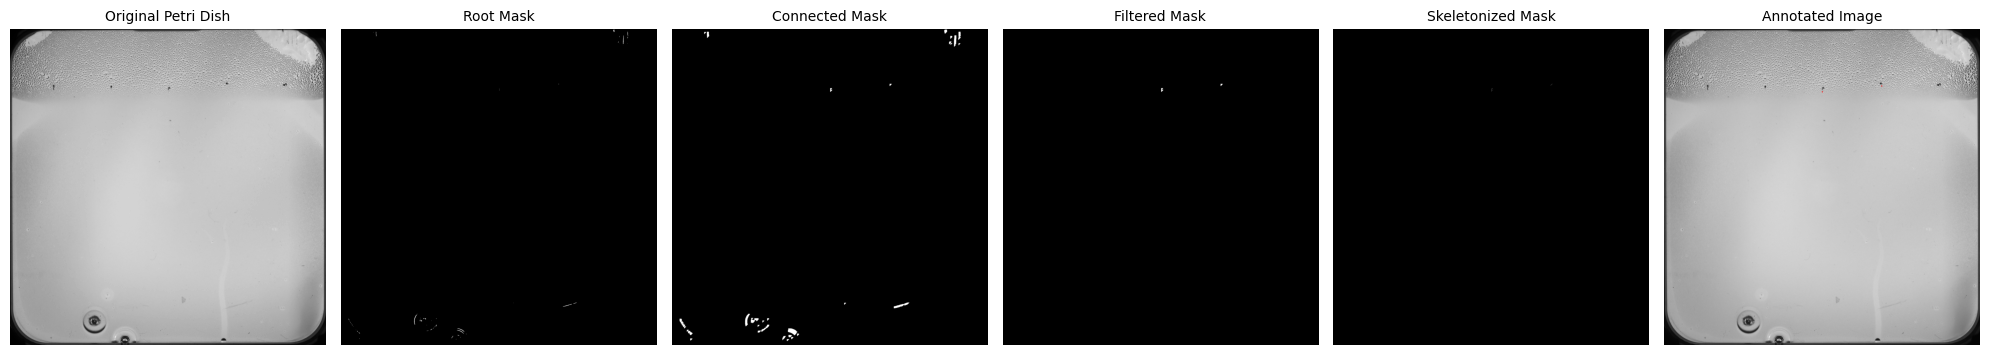

Root Tip Coordinates:
{'Rectangle': 3, 'Pixel Coordinates': (1401, 556), 'MM Coordinates': (75.13407222023596, 29.817661780479085), 'Robot Coordinates': (0.18288407222023595, 0.09181766178047909, 0.057)}
{'Rectangle': 4, 'Pixel Coordinates': (1927, 504), 'MM Coordinates': (103.34286735788345, 27.02895959957097), 'Robot Coordinates': (0.21109286735788346, 0.08902895959957097, 0.057)}


In [7]:
import os
import cv2
import numpy as np
import logging
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Constants
plate_size_mm = 150  # Physical plate size in mm
plate_position_robot = [0.10775, 0.062, 0.057]  # Top-left corner of plate in robot space (Y adjusted)
position_bounds = {
    "x": (-0.1872, 0.253),
    "y": (-0.1705, 0.2195),
    "z": (0.1693, 0.2895),
}
rect_positions = [
    (0.09, 0.135, 0.18, 0.265),
    (0.27, 0.135, 0.36, 0.265),
    (0.45, 0.135, 0.54, 0.285),
    (0.61, 0.135, 0.75, 0.265),
    (0.80, 0.135, 0.95, 0.295),
]

# Preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    return image

# Extract petri dish
def extract_petri_dish(image):
    _, thresholded = cv2.threshold(image, 57, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        logging.warning("No contours detected for Petri dish.")
        return image
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    max_side = max(w, h)
    x_center, y_center = x + w // 2, y + h // 2
    x_start = max(0, x_center - max_side // 2)
    y_start = max(0, y_center - max_side // 2)
    x_end = min(image.shape[1], x_start + max_side)
    y_end = min(image.shape[0], y_start + max_side)
    cropped_image = image[y_start:y_end, x_start:x_end]
    return cropped_image

# Predict root mask using patches
def predict_root_mask(image, model, image_name, patch_size=128, stride=64, batch_size=16):
    h, w = image.shape
    patches, positions = [], []
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y + patch_size, x:x + patch_size]
            patch_rgb = np.stack([patch] * 3, axis=-1)
            patches.append(patch_rgb)
            positions.append((y, x))

    patches = np.array(patches) / 255.0
    predictions = []
    for i in range(0, len(patches), batch_size):
        batch = patches[i:i + batch_size]
        batch_predictions = model.predict(batch, verbose=0)
        predictions.append(batch_predictions)

    predictions = np.vstack(predictions)
    reconstructed = np.zeros((h, w), dtype=np.float32)
    counts = np.zeros((h, w), dtype=np.float32)
    for pred, (y, x) in zip(predictions, positions):
        pred = pred[..., 0]
        reconstructed[y:y + patch_size, x:x + patch_size] += pred
        counts[y:y + patch_size, x:x + patch_size] += 1

    return (reconstructed / np.maximum(counts, 1) > 0.5).astype(np.uint8)

# Connect fragmented roots
def connect_roots(mask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    return cv2.dilate(mask, kernel, iterations=15)

# Filter rectangles and skeletonize roots
def filter_and_skeletonize_roots(mask, rect_positions):
    h, w = mask.shape
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    filtered_mask = np.zeros_like(mask, dtype=np.uint8)
    root_data = []
    for rect_idx, (x_start, y_start, x_end, y_end) in enumerate(rect_positions):
        rect_x_start = int(x_start * w)
        rect_y_start = int(y_start * h)
        rect_x_end = int(x_end * w)
        rect_y_end = int(y_end * h)
        valid_objects = []
        for i in range(1, num_labels):  # Skip background
            area = stats[i, cv2.CC_STAT_AREA]
            object_pixels = np.column_stack(np.where(labels == i))
            if len(object_pixels) > 0:
                highest_point = object_pixels[np.argmin(object_pixels[:, 0])]
                if rect_x_start <= highest_point[1] <= rect_x_end and rect_y_start <= highest_point[0] <= rect_y_end:
                    valid_objects.append((i, area))
        if valid_objects:
            largest_object = max(valid_objects, key=lambda x: x[1])
            root_data.append((rect_idx + 1, largest_object[0]))
            filtered_mask[labels == largest_object[0]] = 255
    skeletonized_mask = skeletonize(filtered_mask > 0).astype(np.uint8) * 255
    return filtered_mask, skeletonized_mask, root_data, labels

# Calculate conversion factor
def calculate_conversion_factor(image):
    plate_size_pixels = image.shape[1]
    return plate_size_mm / plate_size_pixels

def find_and_highlight_root_tips(skeletonized_mask, image, root_data, labels, conversion_factor, output_path):
    """
    Highlight root tips and calculate their coordinates in the robot's environment scale.
    Save the annotated image with root tips highlighted.
    """
    h, w = image.shape
    annotated_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    root_tips = []

    for rect_id, obj_id in root_data:
        single_root_mask = (labels == obj_id).astype(np.uint8)
        coords = np.column_stack(np.where(single_root_mask > 0))
        if len(coords) == 0:
            continue

        # Find the lowest point (max y-coordinate)
        lowest_point = coords[np.argmax(coords[:, 0])]
        y_pixel, x_pixel = lowest_point

        # Convert to MM space
        x_mm = x_pixel * conversion_factor
        y_mm = y_pixel * conversion_factor

        # Convert MM to the robot's scale (meters) and add to base position
        x_robot = (x_mm / 1000) + plate_position_robot[0]
        y_robot = (y_mm / 1000) + plate_position_robot[1]
        z_robot = plate_position_robot[2]

        # Highlight the lowest point on the annotated image
        cv2.circle(annotated_image, (x_pixel, y_pixel), radius=5, color=(0, 0, 255), thickness=-1)

        # Append root tip information
        root_tips.append({
            "Rectangle": rect_id,
            "Pixel Coordinates": (x_pixel, y_pixel),
            "MM Coordinates": (x_mm, y_mm),
            "Robot Coordinates": (x_robot, y_robot, z_robot),
        })

    # Save the annotated image
    cv2.imwrite(output_path, annotated_image)
    logging.info(f"Annotated image saved as: {output_path}")

    return annotated_image, root_tips
# Plot images for each step
def plot_steps(steps):
    fig, axs = plt.subplots(1, len(steps), figsize=(20, 5))
    for idx, (title, img) in enumerate(steps.items()):
        axs[idx].imshow(img if len(img.shape) == 2 else cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap="gray")
        axs[idx].set_title(title, fontsize=10)
        axs[idx].axis("off")
    plt.tight_layout()
    plt.show()

# Load your pre-trained model
MODEL_PATH = "232430_unet_model_128px_v9md_checkpoint.keras"
custom_objects = {"combined_loss": combined_loss, "f1_metric": f1_metric}
model = tf.keras.models.load_model(MODEL_PATH, custom_objects=custom_objects)

# Update the process_image function to include the model and image name
def process_image(image_path):
    logging.info(f"Processing: {os.path.basename(image_path)}")
    image_name = os.path.basename(image_path)
    image = preprocess_image(image_path)
    petri_dish = extract_petri_dish(image)
    root_mask = predict_root_mask(petri_dish, model, image_name)  # Pass the model and image name
    connected_mask = connect_roots(root_mask)
    filtered_mask, skeletonized_mask, root_data, labels = filter_and_skeletonize_roots(connected_mask, rect_positions)
    conversion_factor = calculate_conversion_factor(petri_dish)
    output_image_path = "textures\_plates/01.png"
    annotated_image, root_tips = find_and_highlight_root_tips(
        skeletonized_mask, petri_dish, root_data, labels, conversion_factor, output_image_path
    )
    steps = {
        "Original Petri Dish": petri_dish,
        "Root Mask": root_mask,
        "Connected Mask": connected_mask,
        "Filtered Mask": filtered_mask,
        "Skeletonized Mask": skeletonized_mask,
        "Annotated Image": annotated_image,
    }
    plot_steps(steps)
    print("Root Tip Coordinates:")
    for tip in root_tips:
        print(tip)


# Run the pipeline
image_path = "textures\_plates/030_43-2-ROOT1-2023-08-08_pvdCherry_OD001_Col0_05-Fish Eye Corrected.png"
process_image(image_path)
